In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import holidays

In [65]:
#df_cons = pd.read_excel('datasets/Actual_consumption_202001010000_202011242359.xlsx', skiprows=6,na_values='-')
#df_price = pd.read_excel('datasets/Day-ahead_prices_202001010000_202011242359.xlsx', skiprows=6, na_values='-')
#df_gen = pd.read_excel('datasets/Actual_generation_202001010000_202011242359.xlsx', skiprows=6, na_values='-')

df_cons = pd.read_excel('datasets/Actual_consumption_201901010000_202011302359.xlsx', skiprows=6,na_values='-')
df_price = pd.read_excel('datasets/Day-ahead_prices_201901010000_202011302359.xlsx', skiprows=6, na_values='-')
df_gen = pd.read_excel('datasets/Actual_generation_201901010000_202011302359.xlsx', skiprows=6, na_values='-')

#Concatenate Date + Time and create TimeSeries
df_cons['Date'] = pd.to_datetime(df_cons['Date'] + ' ' + df_cons['Time of day'])
#Create Timeseries index for 
df_cons['Date'] = df_cons['Date'].dt.tz_localize('Europe/Berlin', ambiguous='infer')
#Drop Unused column
df_cons.drop('Time of day', axis=1, inplace=True)
#Create Timeseries index for
df_cons.set_index('Date', inplace=True)
#Convert to GWh for better Visualization
df_cons['Total[MWh]']/=1000
df_cons.rename(columns={'Total[MWh]': 'TotalConsumption[GWh]'}, inplace=True)

#Repeat the same steps for Prices Dataset
df_price['Date'] = pd.to_datetime(df_price['Date'] + ' ' + df_price['Time of day'])
df_price['Date'] = df_price['Date'].dt.tz_localize('Europe/Berlin', ambiguous='infer')
df_price.set_index('Date', inplace=True)
df_price.drop(df_price.columns[[0,2,3,4,5,6,7,8,9,10,11,12,13,14]], axis=1, inplace=True)
#Remove Market Signals
df_price['Germany/Luxembourg[€/MWh]'] = df_price[df_price['Germany/Luxembourg[€/MWh]'] > 1]

#Repeat the same steps for Power Generation Dataset 
df_gen['Date'] = pd.to_datetime(df_gen['Date'] + ' ' + df_gen['Time of day'])
df_gen['Date'] = df_gen['Date'].dt.tz_localize('Europe/Berlin', ambiguous='infer')
df_gen.drop('Time of day', axis=1, inplace=True)
df_gen.set_index('Date', inplace=True)
6
#Create the Total Power Generation Column also known as Sypply
df_gen['TotalGeneration[MWh]'] = (df_gen['Biomass[MWh]'] + 
        df_gen['Hydropower[MWh]']+
        df_gen['Wind offshore[MWh]'] +
        df_gen['Wind onshore[MWh]']+
        df_gen['Photovoltaics[MWh]']+
        df_gen['Other renewable[MWh]']+ 
        df_gen['Nuclear[MWh]']+ 
        df_gen['Fossil brown coal[MWh]']+
        df_gen['Fossil hard coal[MWh]']+ 
        df_gen['Fossil gas[MWh]']+ 
        df_gen['Hydro pumped storage[MWh]']+
        df_gen['Other conventional[MWh]'])

#Convert all columns to GWh
df_gen['TotalGeneration[MWh]']/=1000  
df_gen['Biomass[MWh]']/=1000
df_gen['Hydropower[MWh]']/=1000
df_gen['Wind offshore[MWh]']/=1000
df_gen['Wind onshore[MWh]']/=1000
df_gen['Photovoltaics[MWh]']/=1000
df_gen['Other renewable[MWh]']/=1000
df_gen['Nuclear[MWh]']/=1000
df_gen['Fossil brown coal[MWh]']/=1000
df_gen['Fossil hard coal[MWh]']/=1000
df_gen['Fossil gas[MWh]']/=1000
df_gen['Hydro pumped storage[MWh]']/=1000
df_gen['Other conventional[MWh]']/=1000

df_gen.rename(columns={'TotalGeneration[MWh]': 'TotalGeneration[GWh]',
                       'Biomass[MWh]':'Biomass[GWh]',
                       'Hydropower[MWh]': 'Hydropower[GWh]',
                       'Wind offshore[MWh]': 'Wind offshore[GWh]',
                       'Wind onshore[MWh]':'Wind onshore[GWh]',
                       'Photovoltaics[MWh]':'Photovoltaics[GWh]',
                       'Other renewable[MWh]':'Other renewable[GWh]',
                       'Nuclear[MWh]':'Nuclear[GWh]',
                       'Fossil brown coal[MWh]':'Fossil brown coal[GWh]',
                       'Fossil hard coal[MWh]':'Fossil hard coal[GWh]',
                       'Fossil gas[MWh]':'Fossil gas[GWh]',
                       'Hydro pumped storage[MWh]':'Hydro pumped storage[GWh]',
                       'Other conventional[MWh]':'Other conventional[GWh]'                      
                      }, inplace=True)


#Downsample datasets to a daily frequency 
df_dcons = df_cons.resample('D').sum()
df_dgen = df_gen.resample('D').sum()
df_dprice = df_price.resample('D').median()

#Merge Datasets into a single one
df = pd.merge(df_dcons, df_dgen, left_index=True, right_index=True )
df = pd.merge(df, df_dprice, left_index=True, right_index=True )

#Calculate Non-base Demand According to the chosen paper
df['Non-base Demand[GWh]'] = df['TotalConsumption[GWh]'] - df['Hydropower[GWh]'] - df['Nuclear[GWh]']
#Calculate Supply-Demand Index
df['SupplyDemandIndex[SDI]'] = (df['TotalGeneration[GWh]'] - df['TotalConsumption[GWh]'])/ df['TotalConsumption[GWh]']*100

#Get weekday
df['DoW'] = df.index.dayofweek

#Get holidays in Germany
de_holidays = holidays.DEU()
df['Weekend/Holiday'] = df.apply(lambda x: x.name in de_holidays or x.DoW in [5,6], axis=1)

#Window of 90 Days
window = 90

#remove rolls without prices
df = df[~df['Germany/Luxembourg[€/MWh]'].isnull()]
df['PriceDeviation'] = df['Germany/Luxembourg[€/MWh]'].rolling(window).std(win_type='gaussian')
#For displaying purpose
df['Non-base Demand[10GWh]'] = df['Non-base Demand[GWh]'] / 10

#Calculate Price Spike
df['PriceSpike'] =  df['Germany/Luxembourg[€/MWh]'] > df['Germany/Luxembourg[€/MWh]'].rolling(window).mean() + df['PriceDeviation'] * 2

<AxesSubplot:xlabel='Date'>

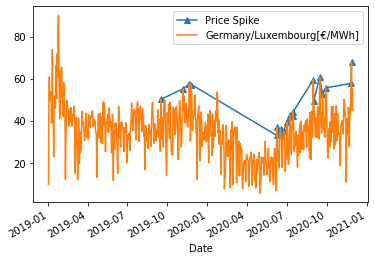

In [66]:
df[df['PriceSpike']]['Germany/Luxembourg[€/MWh]'].plot(marker='^',label='Price Spike', legend=True)
df['Germany/Luxembourg[€/MWh]'].plot(legend=True)

<AxesSubplot:xlabel='Date'>

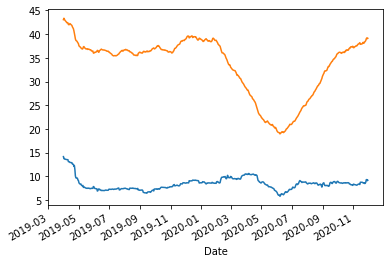

In [67]:
df['PriceDeviation'].plot()
df['Germany/Luxembourg[€/MWh]'].rolling(window).mean().plot()

<AxesSubplot:xlabel='Date'>

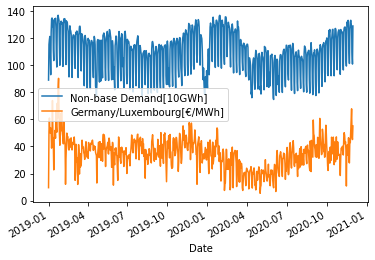

In [68]:
df[['Non-base Demand[10GWh]', 'Germany/Luxembourg[€/MWh]']].plot(legend=True)

<AxesSubplot:xlabel='Date'>

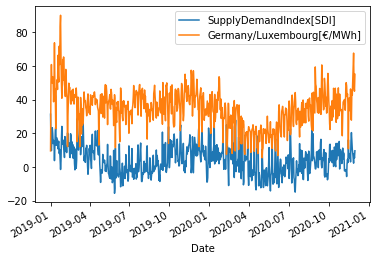

In [69]:
df[['SupplyDemandIndex[SDI]', 'Germany/Luxembourg[€/MWh]']].plot(legend=True)


In [70]:
#Skip Temperature and Capacity-Flow for simplicity

<AxesSubplot:xlabel='TotalConsumption[GWh]', ylabel='Germany/Luxembourg[€/MWh]'>

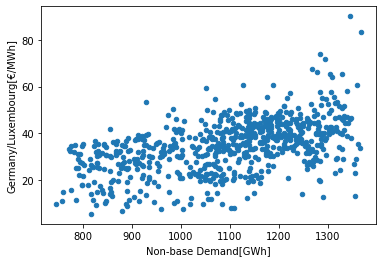

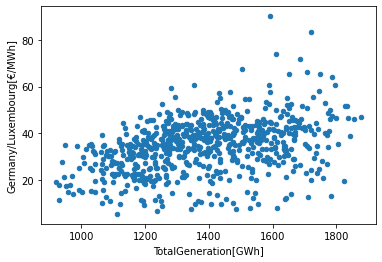

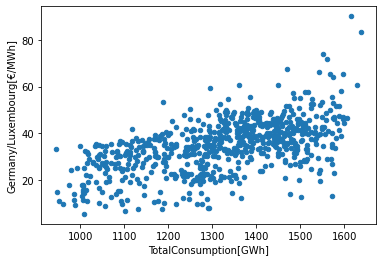

In [71]:
df.plot(kind='scatter', x='Non-base Demand[GWh]' ,y='Germany/Luxembourg[€/MWh]' )
df.plot(kind='scatter', x='TotalGeneration[GWh]' ,y='Germany/Luxembourg[€/MWh]' )
df.plot(kind='scatter', x='TotalConsumption[GWh]' ,y='Germany/Luxembourg[€/MWh]' )

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 699 entries, 2019-01-01 00:00:00+01:00 to 2020-11-30 00:00:00+01:00
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   TotalConsumption[GWh]      699 non-null    float64
 1   Residual load[MWh]         699 non-null    float64
 2   Biomass[GWh]               699 non-null    float64
 3   Hydropower[GWh]            699 non-null    float64
 4   Wind offshore[GWh]         699 non-null    float64
 5   Wind onshore[GWh]          699 non-null    float64
 6   Photovoltaics[GWh]         699 non-null    float64
 7   Other renewable[GWh]       699 non-null    float64
 8   Nuclear[GWh]               699 non-null    float64
 9   Fossil brown coal[GWh]     699 non-null    float64
 10  Fossil hard coal[GWh]      699 non-null    float64
 11  Fossil gas[GWh]            699 non-null    float64
 12  Hydro pumped storage[GWh]  699 non-null    float64
 13  O

In [73]:
df_normal = df[~df['PriceSpike']].copy()

<AxesSubplot:xlabel='Date'>

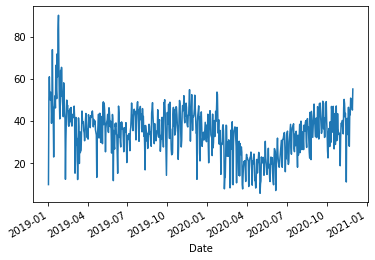

In [74]:
df_normal['Germany/Luxembourg[€/MWh]'].plot()

In [75]:
#Seasonal ARIMA model(SARIMA: Seasonal Auto Regressive Integrated Moving Average) with explanatory variables

from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

<Figure size 432x288 with 0 Axes>

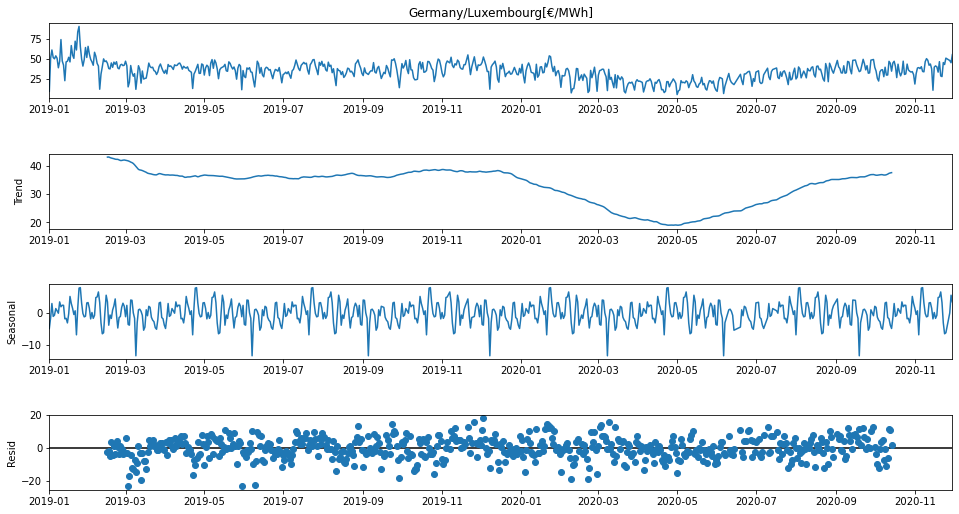

In [76]:
decomposition = seasonal_decompose(df_normal['Germany/Luxembourg[€/MWh]'], period=window)
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

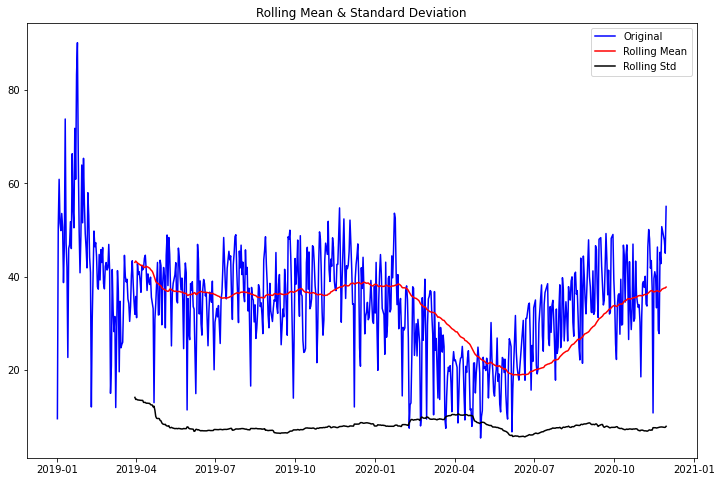

Results of Dickey-Fuller Test:
Test Statistic                  -2.595363
p-value                          0.093959
#Lags Used                      20.000000
Number of Observations Used    655.000000
Critical Value (1%)             -3.440373
Critical Value (5%)             -2.865963
Critical Value (10%)            -2.569125
dtype: float64


In [77]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput) 


test_stationarity(df_normal['Germany/Luxembourg[€/MWh]'])

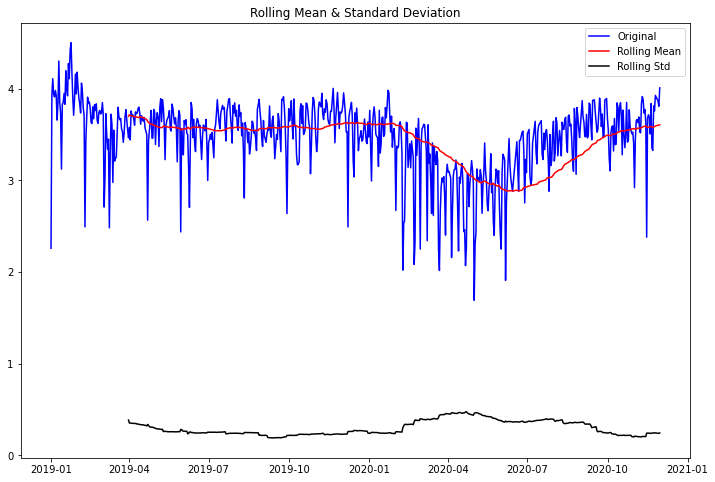

Results of Dickey-Fuller Test:
Test Statistic                  -2.024357
p-value                          0.275997
#Lags Used                      13.000000
Number of Observations Used    662.000000
Critical Value (1%)             -3.440267
Critical Value (5%)             -2.865916
Critical Value (10%)            -2.569100
dtype: float64


In [78]:
df_normal['log(Germany/Luxembourg[€/MWh])']= df_normal['Germany/Luxembourg[€/MWh]'].apply(lambda x: np.log(x))  
test_stationarity(df_normal['log(Germany/Luxembourg[€/MWh])'])
#Worse performance

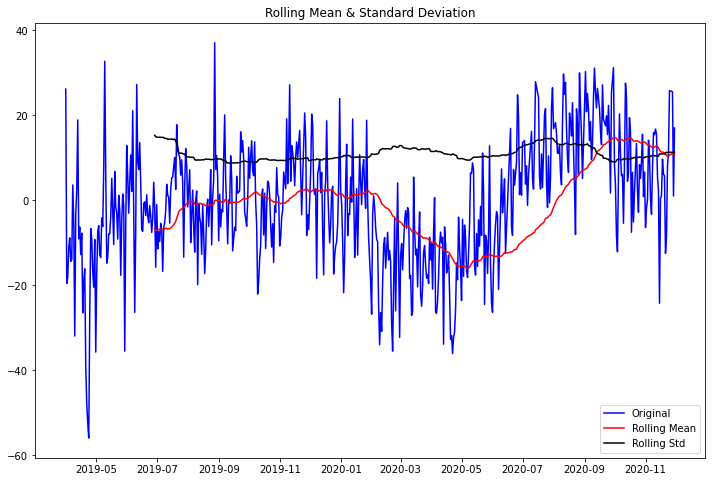

Results of Dickey-Fuller Test:
Test Statistic                  -2.674585
p-value                          0.078540
#Lags Used                      16.000000
Number of Observations Used    569.000000
Critical Value (1%)             -3.441895
Critical Value (5%)             -2.866633
Critical Value (10%)            -2.569482
dtype: float64


In [79]:
df_normal['seasonal_difference'] = df_normal['Germany/Luxembourg[€/MWh]'] - df_normal['Germany/Luxembourg[€/MWh]'].shift(window)  
test_stationarity(df_normal['seasonal_difference'].dropna(inplace=False))
#Much better performance

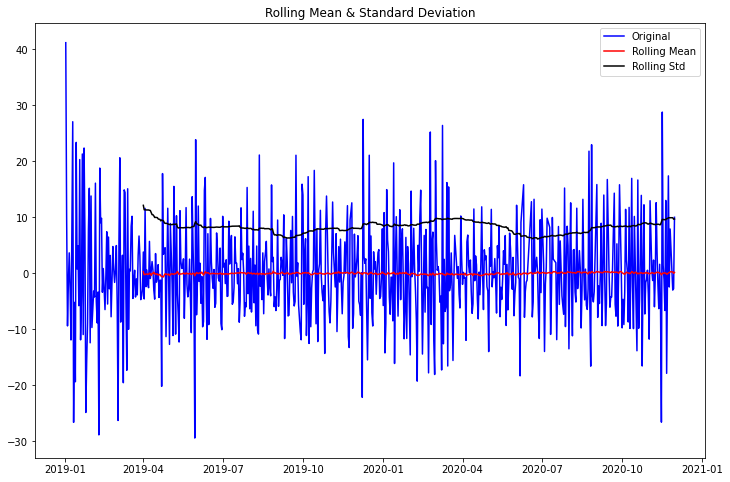

Results of Dickey-Fuller Test:
Test Statistic                -8.450911e+00
p-value                        1.663397e-13
#Lags Used                     1.900000e+01
Number of Observations Used    6.550000e+02
Critical Value (1%)           -3.440373e+00
Critical Value (5%)           -2.865963e+00
Critical Value (10%)          -2.569125e+00
dtype: float64


In [80]:
df_normal['first_difference'] = df_normal['Germany/Luxembourg[€/MWh]'] - df_normal['Germany/Luxembourg[€/MWh]'].shift(1)  
test_stationarity(df_normal['first_difference'].dropna(inplace=False))
#Very significant p-value
#Data normalised 

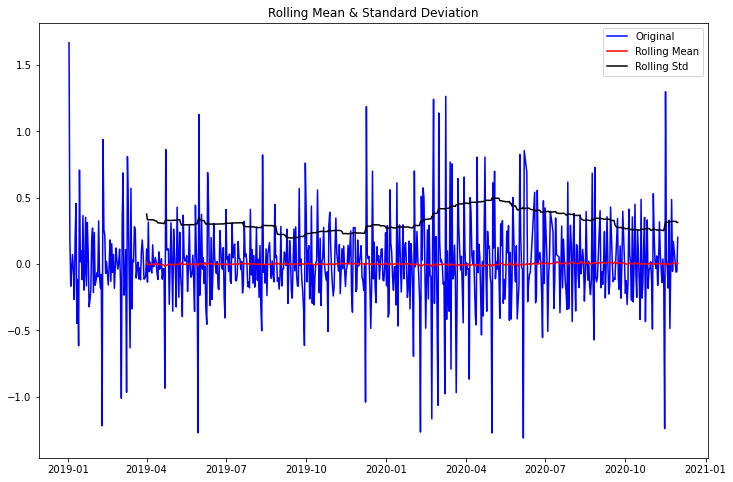

Results of Dickey-Fuller Test:
Test Statistic                -8.246561e+00
p-value                        5.533863e-13
#Lags Used                     1.900000e+01
Number of Observations Used    6.550000e+02
Critical Value (1%)           -3.440373e+00
Critical Value (5%)           -2.865963e+00
Critical Value (10%)          -2.569125e+00
dtype: float64


In [81]:
df_normal['first_difference_log']= df_normal['log(Germany/Luxembourg[€/MWh])'] - df_normal['log(Germany/Luxembourg[€/MWh])'].shift(1)
test_stationarity(df_normal['first_difference_log'].dropna(inplace=False))

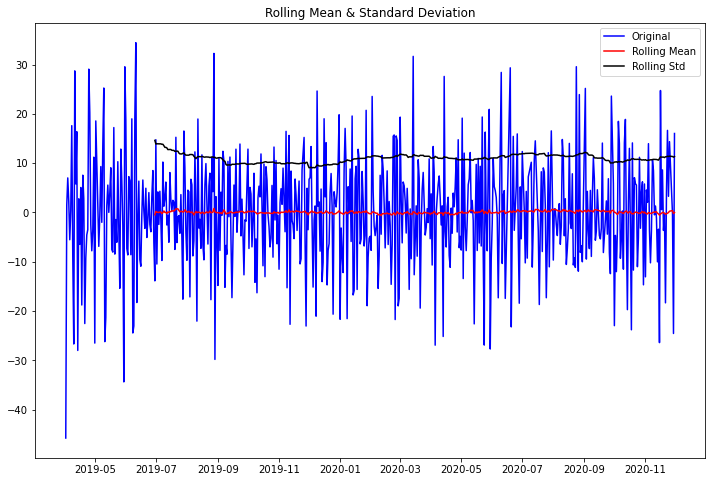

Results of Dickey-Fuller Test:
Test Statistic                -8.662441e+00
p-value                        4.782101e-14
#Lags Used                     1.300000e+01
Number of Observations Used    5.710000e+02
Critical Value (1%)           -3.441854e+00
Critical Value (5%)           -2.866615e+00
Critical Value (10%)          -2.569473e+00
dtype: float64


In [82]:
df_normal['seasonal_first_difference'] = df_normal['first_difference'] - df_normal['first_difference'].shift(window)  
test_stationarity(df_normal.seasonal_first_difference.dropna(inplace=False))
#Very Significant but not as much as the previous one

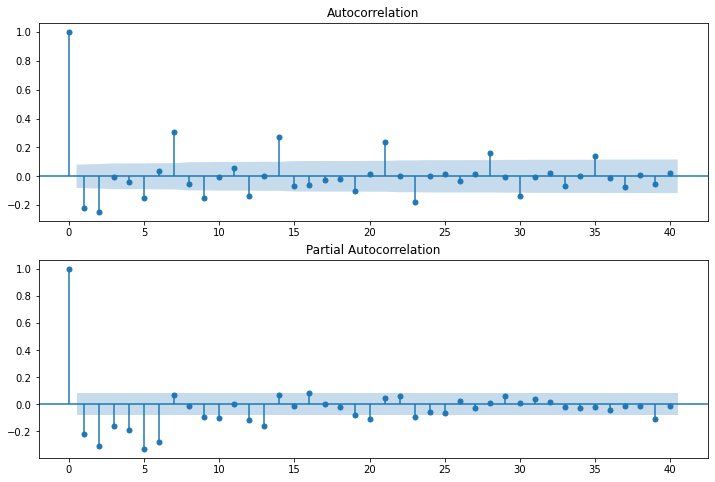

In [83]:
#Model Chosen 'first_difference'
#test_stationarity(df['first_difference'].dropna(inplace=False))

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_normal['first_difference'].iloc[window+1:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_normal['first_difference'].iloc[window+1:], lags=40, ax=ax2)

In [ ]:
#Set index to period Day
try:
    df_normal = df_normal.asfreq('D')
    df_normal.index = pd.DatetimeIndex(df.index).to_period('D')
except:
    ar=1
    
ar = 2           # this is the maximum degree specification
#ma = (1,0,0,1)  # this is the lag polynomial specification
#ar = 0
ma = (1,1)
order = (ar,1,ma) #1 to get the first difference

sar = 1       #Seasonal AR specification, 
sio = 1       #Seasonal Integration order [1 to take the first diffrence] 
sma = 0
#sma = window  #Seasonal MA [Window for Moving Average] 
sp = 365      #Seasonal periodicity [365 for daily dataset]

seasonal_order = (sar,sio,sma,sp)

mod_sarima = sm.tsa.statespace.SARIMAX(df_normal['Germany/Luxembourg[€/MWh]'], trend='n', order=order, seasonal_order=seasonal_order,simple_differencing=True)
results_sarima = mod_sarima.fit()
results_sarima.summary()

/home/cronos/.local/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1101: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
/home/cronos/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/cronos/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:865: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [ ]:
df_normal['forecast_sarima'] = results_sarima.predict(start = 650, end= 699)  # ,dynamic= True)  
df_normal[['Germany/Luxembourg[€/MWh]', 'forecast_sarima']].plot(figsize=(12, 8))

In [88]:
#Set index to period Day
try:
    df_normal = df_normal.asfreq('D')
    df_normal.index = pd.DatetimeIndex(df.index).to_period('D')
except:
    ar=1
    
ar = 2           # this is the maximum degree specification
#ma = (1,0,0,1)  # this is the lag polynomial specification
#ar = 0
ma = 1
order = (ar,1,ma) #1 to get the first difference

#seasonal_order = (sar,sio,sma,sp)

mod_arima = sm.tsa.statespace.SARIMAX(df_normal['Germany/Luxembourg[€/MWh]'], trend='n', order=order)
results_arima = mod_arima.fit()
results_arima.summary()

/home/cronos/.local/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1101: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                                   SARIMAX Results                                   
=====================================================================================
Dep. Variable:     Germany/Luxembourg[€/MWh]   No. Observations:                  700
Model:                      SARIMAX(2, 1, 1)   Log Likelihood               -2334.902
Date:                       Sun, 03 Jan 2021   AIC                           4677.804
Time:                               15:30:14   BIC                           4696.002
Sample:                           01-01-2019   HQIC                          4684.839
                                - 11-30-2020                                         
Covariance Type:                         opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4099      0.040     10.274      0.000       0.332       0.488
ar.L2         -0.1556      0.040     -3.844      0.000      -0.235      -0.076
ma.L1         -0.8919      0.023    -38.045      0.000      -0.938      -0.846
sigma2        58.6612      2.228     26.325      0.000      54.294      63.029
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               184.36
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.59   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='Date'>

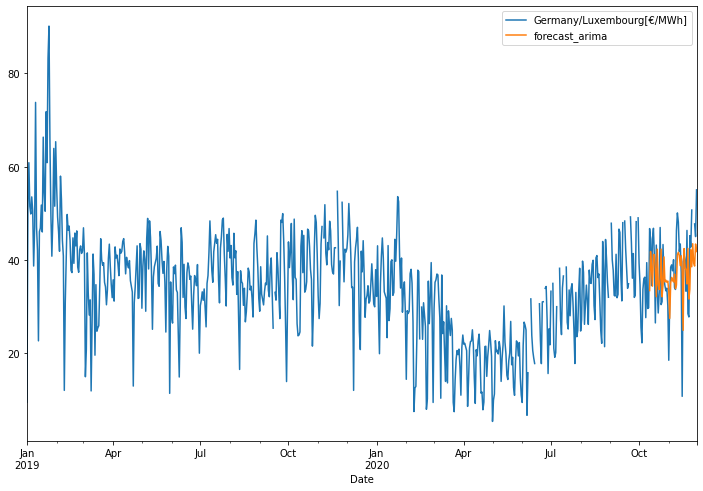

In [89]:
df_normal['forecast_arima'] = results_arima.predict(start = 650, end= 699)  # ,dynamic= True)  
df_normal[['Germany/Luxembourg[€/MWh]', 'forecast_arima']].plot(figsize=(12, 8))